In [2]:
import sys
sys.path.append('../src')
from evaluation import evaluate_precision_recall
from recommender import train_user_based_cf, get_top_n_recommendations
from surprise import accuracy
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%run ./03_item_based_cf.ipynb

Computing the cosine similarity matrix...
Done computing similarity matrix.

RMSE for Item-Based CF:
RMSE: 1.0264

Top-5 Recommendations for User 1 (Item-Based CF):
Movie: Coldblooded (1995), Predicted Rating: 4.53
Movie: Cyclo (1995), Predicted Rating: 4.50
Movie: Visitors, The (Visiteurs, Les) (1993), Predicted Rating: 4.47
Movie: Chairman of the Board (1998), Predicted Rating: 4.33
Movie: Hearts and Minds (1996), Predicted Rating: 4.28

Saved Top-N recommendations to '../results/top_n_recommendations.csv'


In [4]:
algo_user = train_user_based_cf(trainset)
predictions_user = algo_user.test(testset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [5]:
rmse_user = accuracy.rmse(predictions_user, verbose=False)
precision_user, recall_user = evaluate_precision_recall(predictions_user, k=5, threshold=4.0)

In [6]:
rmse_item = accuracy.rmse(predictions_item, verbose=False)
precision_item, recall_item = evaluate_precision_recall(predictions_item, k=5, threshold=4.0)

In [7]:
print("User-Based CF Metrics:")
print(f"RMSE: {rmse_user:.3f}")
print(f"Precision@5: {precision_user:.3f}")
print(f"Recall@5: {recall_user:.3f}")

User-Based CF Metrics:
RMSE: 1.019
Precision@5: 0.677
Recall@5: 0.267


In [8]:
print("\nItem-Based CF Metrics:")
print(f"RMSE: {rmse_item:.3f}")
print(f"Precision@5: {precision_item:.3f}")
print(f"Recall@5: {recall_item:.3f}")


Item-Based CF Metrics:
RMSE: 1.026
Precision@5: 0.319
Recall@5: 0.134


In [13]:
user_ids = [1, 2, 3] 
all_recommendations = []

for user_id in user_ids:
    top_n_user = get_top_n_recommendations(algo_user, user_id, movies, ratings, n=5)
    user_based_df = pd.DataFrame(top_n_user, columns=['movie_id', 'title', 'predicted_rating'])
    user_based_df['user_id'] = user_id
    user_based_df['model_type'] = 'user_based'
    user_based_df = user_based_df[['user_id', 'model_type', 'movie_id', 'title', 'predicted_rating']]
    
    top_n_item = get_top_n_recommendations(algo_item, user_id, movies, ratings, n=5)
    item_based_df = pd.DataFrame(top_n_item, columns=['movie_id', 'title', 'predicted_rating'])
    item_based_df['user_id'] = user_id
    item_based_df['model_type'] = 'item_based'
    item_based_df = item_based_df[['user_id', 'model_type', 'movie_id', 'title', 'predicted_rating']]
    
    recommendations_df = pd.concat([user_based_df, item_based_df], ignore_index=True)
    all_recommendations.append(recommendations_df)

In [14]:
final_recommendations_df = pd.concat(all_recommendations, ignore_index=True)

In [15]:
file_path = '../results/top_n_recommendations.csv'
if os.path.exists(file_path):
    final_recommendations_df.to_csv(file_path, mode='a', header=False, index=False)
else:
    final_recommendations_df.to_csv(file_path, mode='w', header=True, index=False)
print("\nAppended Top-N recommendations for multiple users to '../results/top_n_recommendations.csv'")


Appended Top-N recommendations for multiple users to '../results/top_n_recommendations.csv'


In [16]:
metrics = {
    'user_based': {
        'rmse': float(rmse_user),
        'precision_at_5': float(precision_user),
        'recall_at_5': float(recall_user)
    },
    'item_based': {
        'rmse': float(rmse_item),
        'precision_at_5': float(precision_item),
        'recall_at_5': float(recall_item)
    }
}
with open('../results/evaluation_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=4)
print("\nSaved evaluation metrics to '../results/evaluation_metrics.json'")

# قراءة الملف وطباعة محتواه
with open('../results/evaluation_metrics.json', 'r') as f:
    saved_metrics = json.load(f)
print("\nContent of evaluation_metrics.json:")
print(saved_metrics)


Saved evaluation metrics to '../results/evaluation_metrics.json'

Content of evaluation_metrics.json:
{'user_based': {'rmse': 1.0193536815834319, 'precision_at_5': 0.6767198581560284, 'recall_at_5': 0.26704227335631125}, 'item_based': {'rmse': 1.0264295933767333, 'precision_at_5': 0.31897163120567373, 'recall_at_5': 0.1338566893797224}}


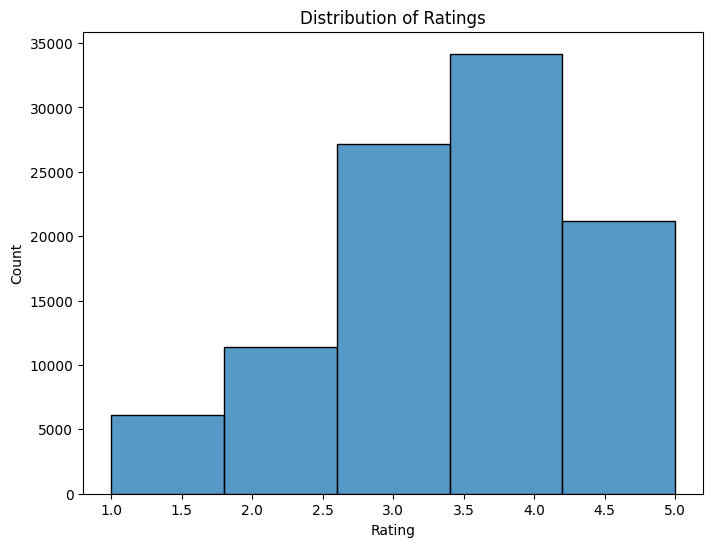

In [17]:
plt.figure(figsize=(8, 6))
sns.histplot(ratings['rating'], bins=5, kde=False)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

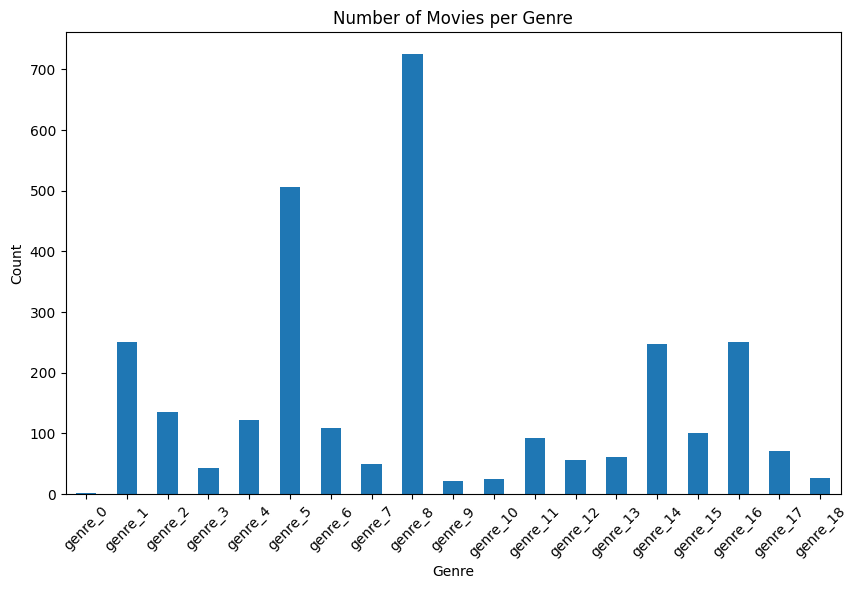

In [18]:
genre_columns = [col for col in movies.columns if col.startswith('genre_')]
genre_counts = movies[genre_columns].sum()
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar')
plt.title('Number of Movies per Genre')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

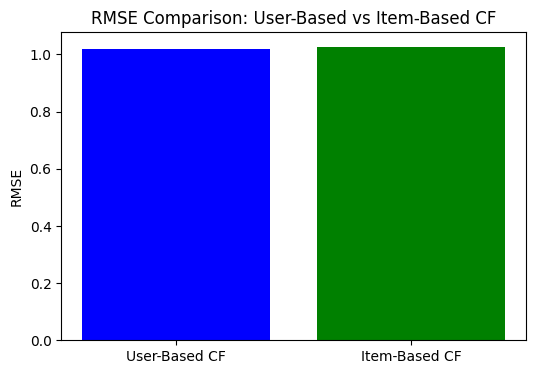

In [19]:
plt.figure(figsize=(6, 4))
models = ['User-Based CF', 'Item-Based CF']
rmse_values = [rmse_user, rmse_item]
plt.bar(models, rmse_values, color=['blue', 'green'])
plt.title('RMSE Comparison: User-Based vs Item-Based CF')
plt.ylabel('RMSE')
plt.show()